In [1]:
import numpy as np
import torch
from scipy.stats import gaussian_kde

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


import pickle
from tqdm import tqdm 


In [2]:
with open(f'./sample_sigma.pkl', 'rb') as pickle_file:
    samples = pickle.load(pickle_file)
sigma = list(samples.keys())

mean_for_hist = {}
mae = {}
rmse = {}
std = {}

percentile_68_width = {}
percentile_99_width = {}
for s in tqdm(sigma):
    mae[s] = []
    rmse[s] = []
    std[s] = []
    mean_for_hist[s] = {}
    
    percentile_68_width[s] = []
    percentile_99_width[s] = []
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pikle_file:
        true_values = pickle.load(pikle_file)
    dict_of_samples = samples[s]
    for key in dict_of_samples.keys():
        sample_values = dict_of_samples[key].cpu().numpy()
        mean_of_samples = np.mean(dict_of_samples[key].cpu().numpy())
        true_value = true_values[key]['params'][0]
        mae[s].append(np.abs(mean_of_samples - true_value))
        rmse[s].append((mean_of_samples - true_value)**2)
        std[s].append(np.std(sample_values))
        
        # Calculate 68% and 99% percentile widths
        p16, p84 = np.percentile(sample_values, [16, 84])
        p05, p995 = np.percentile(sample_values, [0.5, 99.5])
        percentile_68_width[s].append(p84 - p16)
        percentile_99_width[s].append(p995 - p05)
        
        if 'samples' in mean_for_hist[s].keys():
            mean_for_hist[s]['samples'].append(mean_of_samples)
            mean_for_hist[s]['true'].append(true_value)
        else:
            mean_for_hist[s]['samples'] = [mean_of_samples]
            mean_for_hist[s]['true'] = [true_value] 
        
    mae[s] = np.mean(mae[s])     
    rmse[s] = np.sqrt(np.mean(rmse[s]))
    std[s] = np.mean(std[s])
    percentile_68_width[s] = np.mean(percentile_68_width[s])
    percentile_99_width[s] = np.mean(percentile_99_width[s])

100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


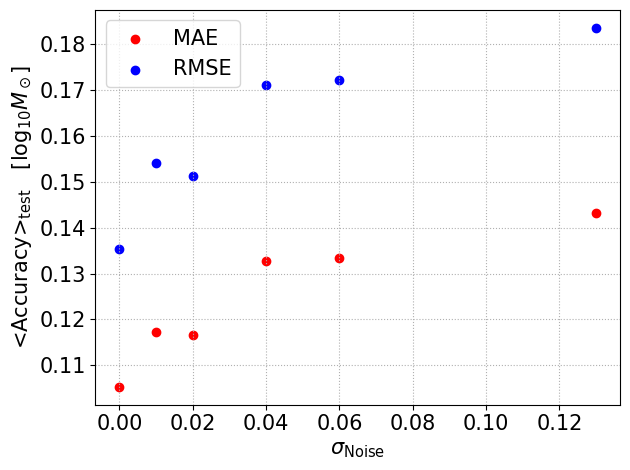

In [3]:
plt.scatter(mae.keys(), mae.values(), label='MAE', c='r')
plt.scatter(rmse.keys(), rmse.values(), label='RMSE', c='b')

# plt.xscale('log')
plt.xlabel(fr'$\sigma_{{\text{{Noise}}}}$', fontsize=15)
plt.legend(fontsize=15)
plt.ylabel(fr'<Accuracy>$_{{\text{{test}}}} \quad [\text{{log}}_{{10}} M_\odot]$', fontsize=15)
plt.grid(linestyle='dotted')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig(f'./script/uncertanties_testing/mae_rmse.pdf')

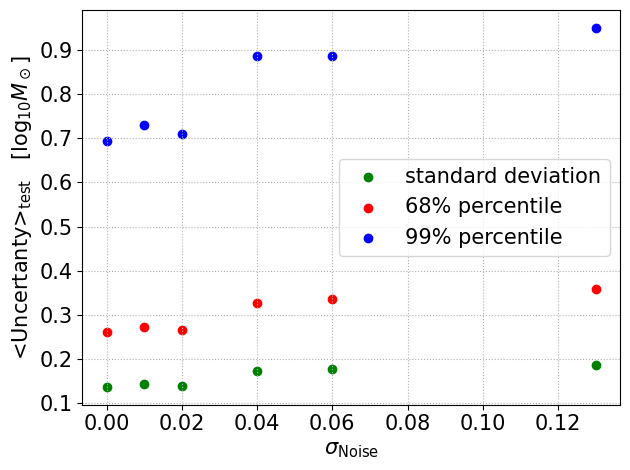

In [54]:
plt.scatter(std.keys(), std.values(), label='standard deviation', c='g')
plt.scatter(percentile_68_width.keys(), percentile_68_width.values(), label='68% percentile', c='r')
plt.scatter(percentile_99_width.keys(), percentile_99_width.values(), label='99% percentile', c='b')

plt.legend(fontsize=15)
plt.xlabel(fr'$\sigma_{{\text{{Noise}}}}$', fontsize=15)
plt.ylabel(fr'<Uncertanty>$_{{\text{{test}}}} \quad [\text{{log}}_{{10}} M_\odot]$', fontsize=15)
plt.grid(linestyle='dotted')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig(f'./script/uncertanties_testing/uncertanty.pdf')

In [20]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

kl_div = {}
js_div = {}

for s in tqdm(sigma):
    kl_div[s] = []
    js_div[s] = []
    
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pikle_file:
            true_values = pickle.load(pikle_file)
    dict_of_samples = samples[s]
    #for each galaxy in the test set, so 0<j<100
    for j in range(100):
        #create the histogram of the true values and the samples
        hist_true = []
        hist_samples = []
        #take the keys only for the j-th galaxy
        keys_with_give_j = [key for key in true_values.keys() if key[1] == j]
        for key in keys_with_give_j:
            hist_true.append(true_values[key]['params'][0])
            hist_samples.append(np.mean(dict_of_samples[key].cpu().numpy()))
        
        hist_true = hist_true/np.sum(hist_true)
        hist_samples = hist_samples/np.sum(hist_samples)    
        
        #take the kl and js div between the two histograms and append it to the dictionary     
        kl_div[s].append(entropy(hist_true, hist_samples))
        js_div[s].append(jensenshannon(hist_true, hist_samples))
    
    #take the average of kl and js div on the test set    
    kl_div[s] = np.mean(kl_div[s])
    js_div[s] = np.mean(js_div[s])
        

100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


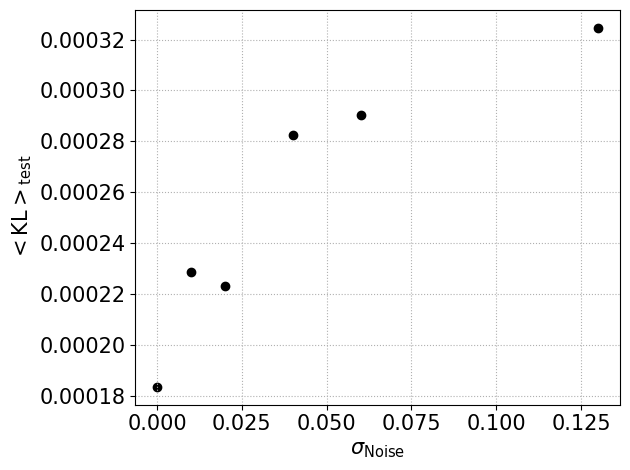

In [53]:
plt.scatter(kl_div.keys(), kl_div.values(), label='KL div', c='black')
plt.xlabel(fr'$\sigma_{{\text{{Noise}}}}$', fontsize=15)
plt.ylabel(r'$<\text{KL}>_{\text{test}}$ ', fontsize=15)
plt.grid(linestyle='dotted')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig(f'./script/uncertanties_testing/kl_div.pdf')

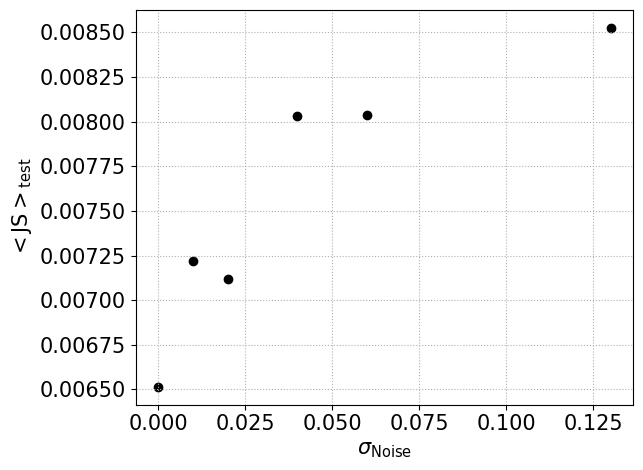

In [52]:
plt.scatter(js_div.keys(), js_div.values(), label='KL div', c='black')
plt.xlabel(fr'$\sigma_{{\text{{Noise}}}}$', fontsize=15)
plt.ylabel(r'$<\text{JS}>_{\text{test}}$ ', fontsize=15)
plt.grid(linestyle='dotted')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig(f'./script/uncertanties_testing/js_div.pdf')   

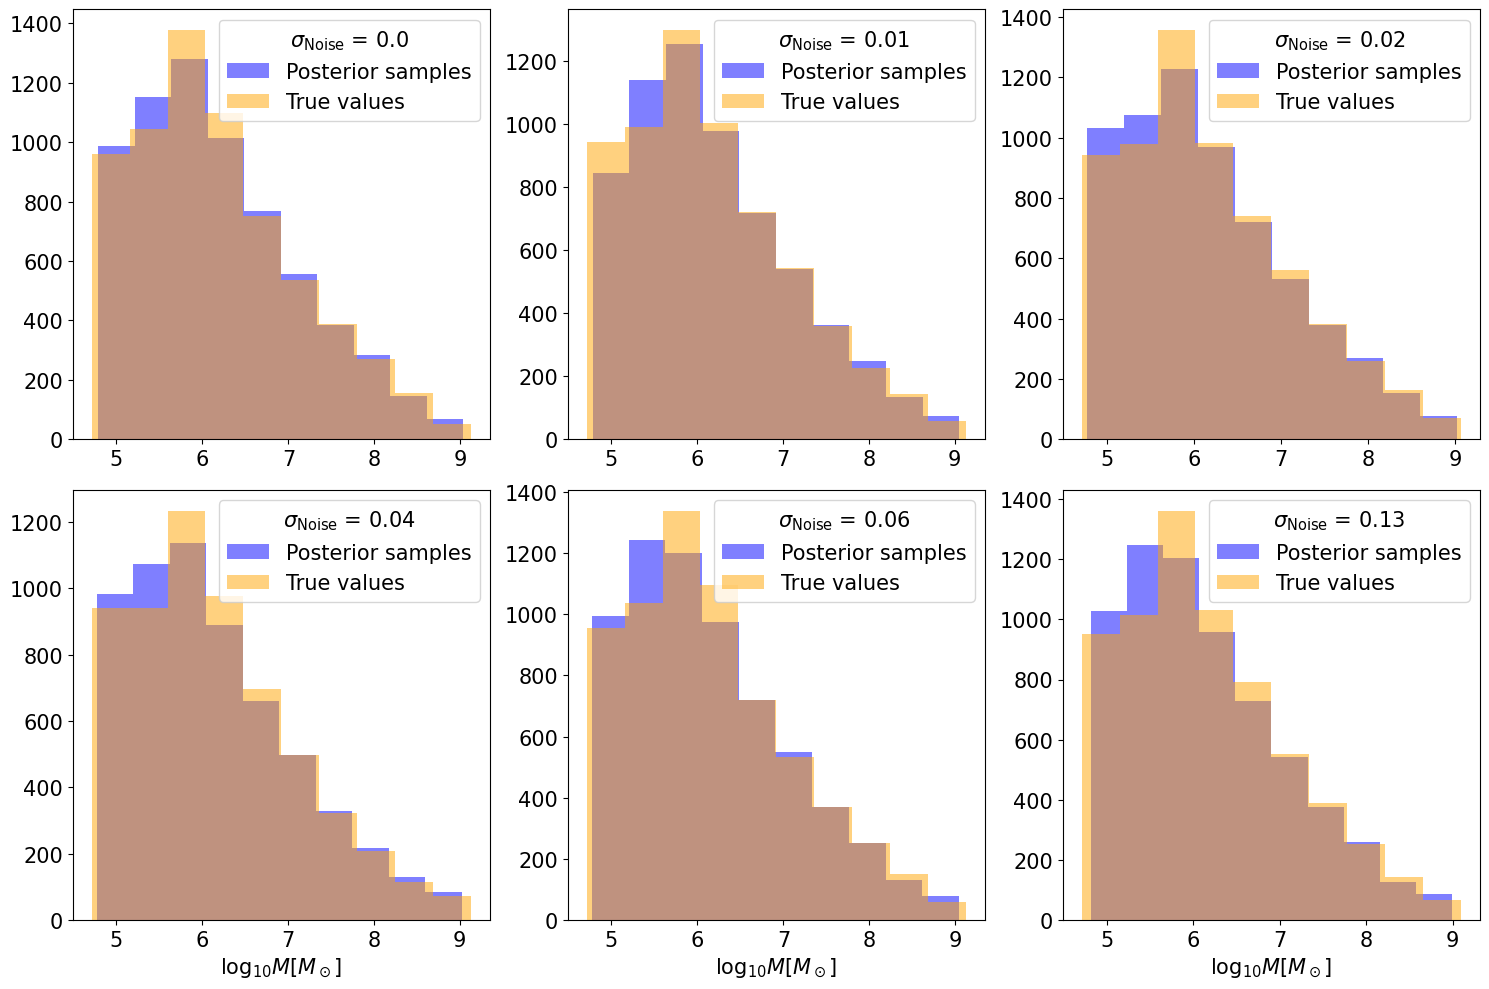

In [9]:
fig = plt.figure(figsize=(15, 10), layout = 'tight')

for i, s in enumerate(sigma):
    ax = fig.add_subplot(2, 3, i+1)
    ax.hist(mean_for_hist[s]['samples'], alpha=0.5, color='blue', label='Posterior samples', )
    ax.hist(mean_for_hist[s]['true'], alpha=0.5, color='orange', label='True values', )
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yscale('log')
    if i+1 > 3:
        ax.set_xlabel(r'$\text{log}_{10} M [M_\odot] $', fontsize=15)
    legend = ax.legend(title=fr'$\sigma_{{\text{{Noise}}}}$ = {s}',fontsize=15)
    plt.setp(legend.get_title(), fontsize=15, ha='left')
    

In [40]:
dataframe = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')


feh_min, feh_max = dataframe['feh'].min(), dataframe['feh'].max()
ofe_min, ofe_max = dataframe['ofe'].min(), dataframe['ofe'].max()

/tmp/ipykernel_752207/3945495562.py:24: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(arr), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr),  extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')
/tmp/ipykernel_752207/3945495562.py:24: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(arr), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr),  extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')
/tmp/ipykernel_752207/3945495562.py:24: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(arr), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr),  extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')
/tmp/ipykernel_752207/3945495562.py:24: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(arr), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr),  extent=[feh_min, feh_max, ofe_min, o

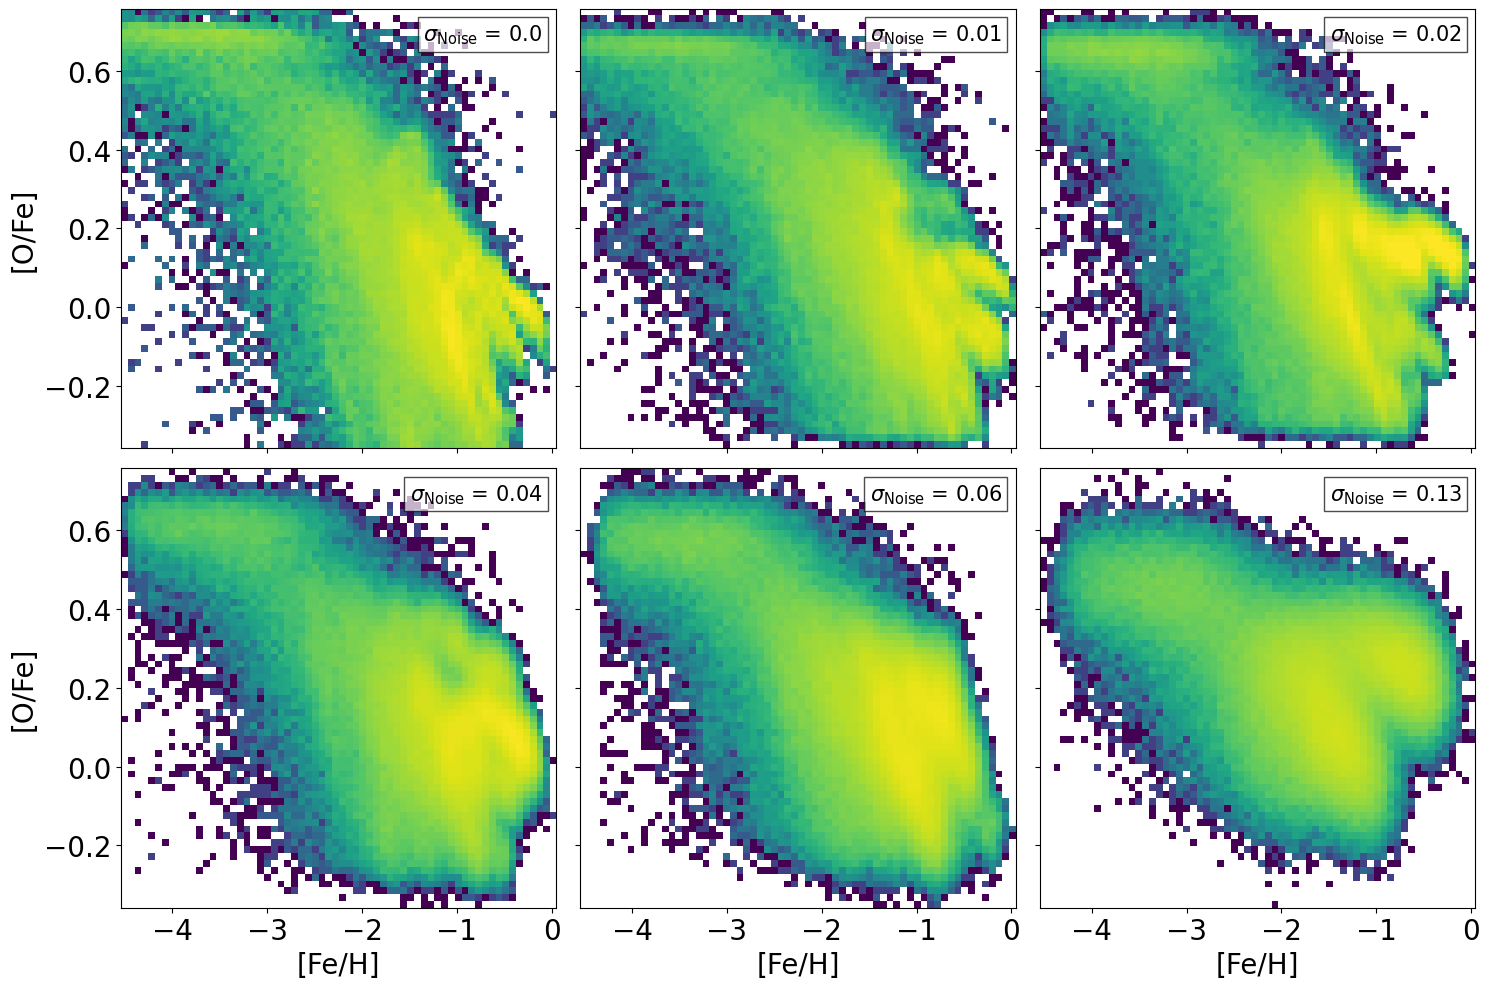

In [101]:
min_arr = 1000
max_arr = 0
for i, s in enumerate(sigma):
    # Load dictionary from a pickle file
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pickle_file:
        data = pickle.load(pickle_file)
    arr = data[(0, 16)]['x'].T
    if arr[arr != 0].min() < min_arr:
        min_arr = arr[arr != 0].min()
    if arr.max() > max_arr:
        max_arr = arr.max() 

fig = plt.figure(figsize=(15, 10), layout='tight',)


num_rows = 2
num_cols = 3
for i, s in enumerate(sigma):
    # Load dictionary from a pickle file
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pickle_file:
        data = pickle.load(pickle_file)
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    arr = data[(0, 0)]['x'].T
    ax.imshow(np.log10(arr), origin='lower', vmin=np.log10(min_arr), vmax=np.log10(max_arr),  extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')
    # ax.imshow(arr, origin='lower',  extent=[feh_min, feh_max, ofe_min, ofe_max], aspect='auto', cmap='viridis')


     # Add text inside a box using annotate
    ax.annotate(
        fr'$\sigma_{{\text{{Noise}}}}$ = {s}', xy=(1, 1), xycoords='axes fraction', fontsize=15,
        xytext=(-10, -10), textcoords='offset points', ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )
    
    # Set x-tick labels only for the bottom row
    if i // num_cols == num_rows - 1:
        ax.set_xlabel('[Fe/H]', fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
    else:
        ax.set_xticklabels([])
    
    # Set y-tick labels only for the first column
    if i % num_cols == 0:
        ax.set_ylabel('[O/Fe]', fontsize=20)
        ax.tick_params(axis='y', labelsize=20)
    else:
        ax.set_yticklabels([])

fig.savefig(f'./script/uncertanties_testing/observations_sigma.pdf')
    


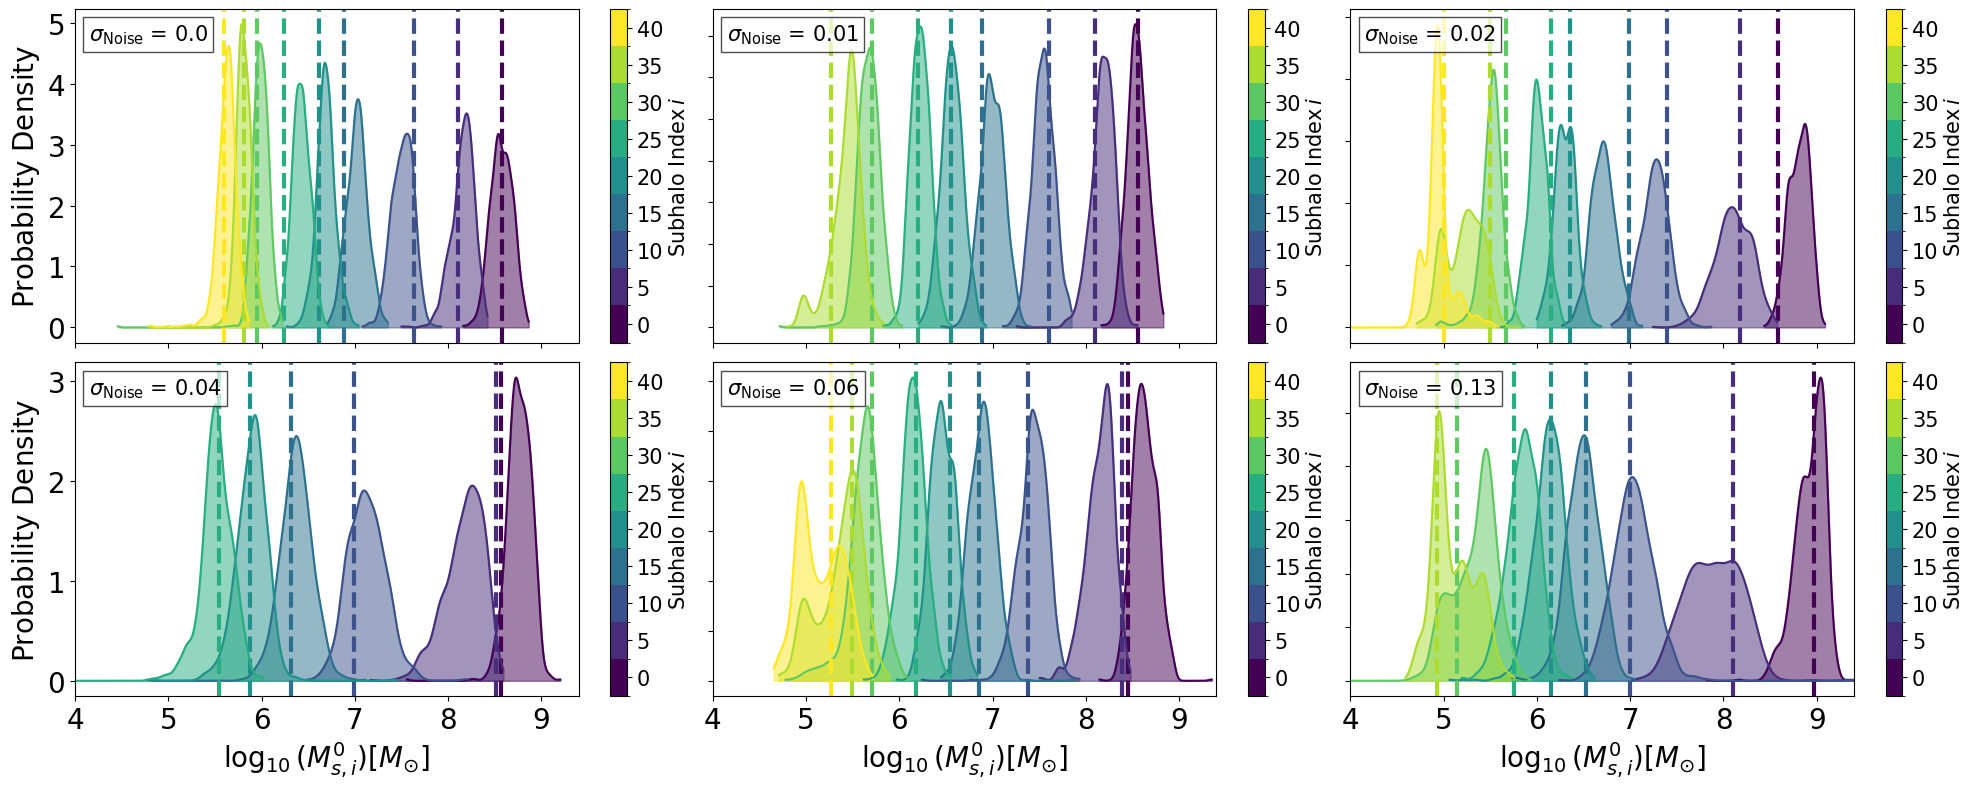

In [4]:
with open(f'./sample_sigma.pkl', 'rb') as pickle_file:
    samples = pickle.load(pickle_file)
sigma = list(samples.keys())

fig = plt.figure(figsize=(20, 8), layout='tight',)
num_rows = 2
num_cols = 3
for p, s in enumerate(sigma):
    ax = fig.add_subplot(num_rows, num_cols, p+1) 
    
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pikle_file:
        true_values = pickle.load(pikle_file)
    dict_of_samples = samples[s]
    
    i_to_plot = [0, 2, 8, 16, 24, 32, 48, 56, 64]
    keys_to_plot = [key for key in true_values.keys() if (key[1] == 0 and key[0] in i_to_plot)]
    
    # Create a colormap
    # cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name
    cmap = mpl.colormaps['viridis']
    # Create a list of colors
    colors = [cmap(i) for i in np.linspace(0, 1, len(i_to_plot))]  # Replace 8 with the number of colors you want
    
    for (c, k) in enumerate(keys_to_plot):
        samples_with_k = dict_of_samples[k].cpu().numpy()
        true_value = true_values[k]['params'][0]
        density = gaussian_kde(samples_with_k)
        density_val = density(np.linspace(min(samples_with_k), max(samples_with_k), 1000))
        ax.plot(np.linspace(min(samples_with_k), max(samples_with_k), 1000), density_val, color=colors[c])    
        ax.fill_between(np.linspace(min(samples_with_k), max(samples_with_k), 1000), density_val, alpha=0.5, color=colors[c])
        ax.axvline(x=true_value, color=colors[c], linestyle='--', linewidth=3)
    
    ax.set_xlim(left=4, right=9.4)
    
    if p // num_cols == num_rows - 1:
        ax.set_xlabel(r'$\log_{10}(M_{s,i}^0) [M_{\odot}]$', fontsize=20)
        ax.tick_params(axis='x', labelsize=20)
    else:
        ax.set_xticklabels([])
        
    if p % num_cols == 0:
        ax.set_ylabel(r'$\text{Probability Density}$', fontsize=20)
        ax.tick_params(axis='y', labelsize=20)
    else:
        ax.set_yticklabels([])    
        
     # Add text inside a box using annotate
    ax.annotate(
        fr'$\sigma_{{\text{{Noise}}}}$ = {s}', xy=(0, 1), xycoords='axes fraction', fontsize=15,
        xytext=(10, -10), textcoords='offset points', ha='left', va='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )
    
    #Colorbar 
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(i_to_plot), 1), ncolors=cmap.N)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(len(i_to_plot)))
    cbar.ax.set_yticklabels([f'{i*5}' for i in range(len(i_to_plot))], fontsize=15)  # Set the labels for the colorbar
    cbar.set_label(r'$\text{Subhalo Index} \, i$', fontsize=15)
    
fig.savefig(f'./script/uncertanties_testing/posterior_samples_sigma.pdf')
        

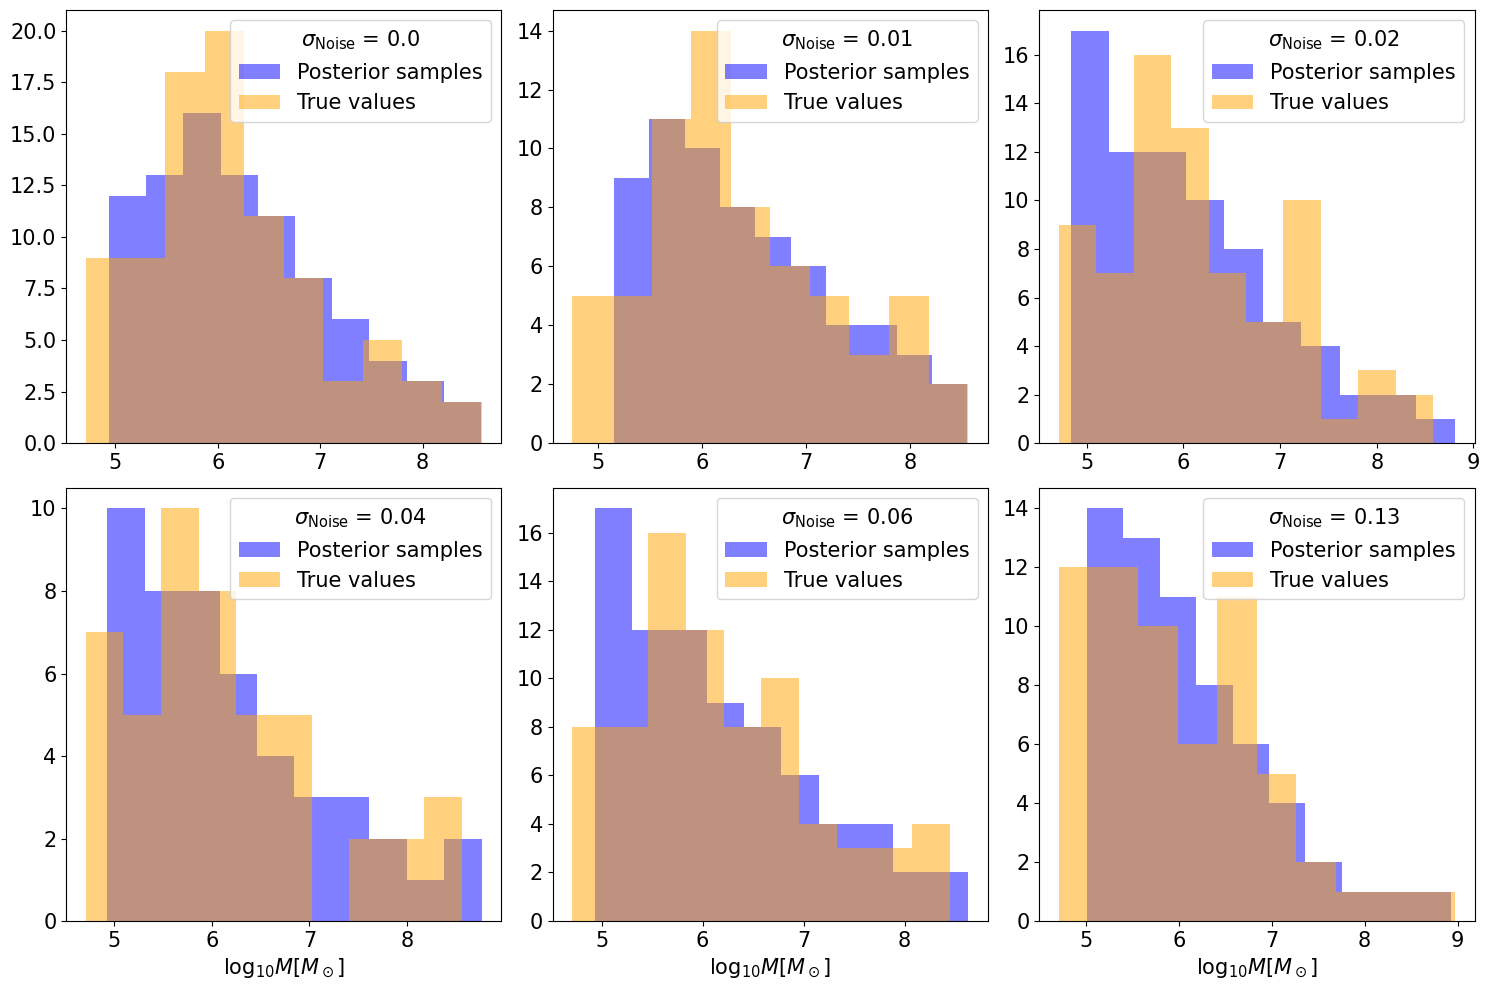

In [31]:
fig = plt.figure(figsize=(15, 10), layout = 'tight')
for p, s in enumerate(sigma):
    mean_of_samples = []
    true_value = []
    with open(f'./script/uncertanties_testing/test_set/test_set_{s}.pkl', 'rb') as pikle_file:
        true_values = pickle.load(pikle_file)
    dict_of_samples = samples[s]
    
    keys_with_j_zero = [key for key in true_values.keys() if key[1] == 0]

    for k in keys_with_j_zero:
        mean_of_samples.append(np.mean(dict_of_samples[k].cpu().numpy()))
        true_value.append(true_values[k]['params'][0])
    
    ax = fig.add_subplot(num_rows, num_cols, p+1)
    ax.hist(mean_of_samples, alpha=0.5, bins=10, color='blue', label='Posterior samples', )
    ax.hist(true_value, alpha=0.5, bins=10, color='orange', label='True values', )
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yscale('log')
    if p+1 > 3:
        ax.set_xlabel(r'$\text{log}_{10} M [M_\odot] $', fontsize=15)
    legend = ax.legend(title=fr'$\sigma_{{\text{{Noise}}}}$ = {s}',fontsize=15)
    plt.setp(legend.get_title(), fontsize=15, ha='left')

    


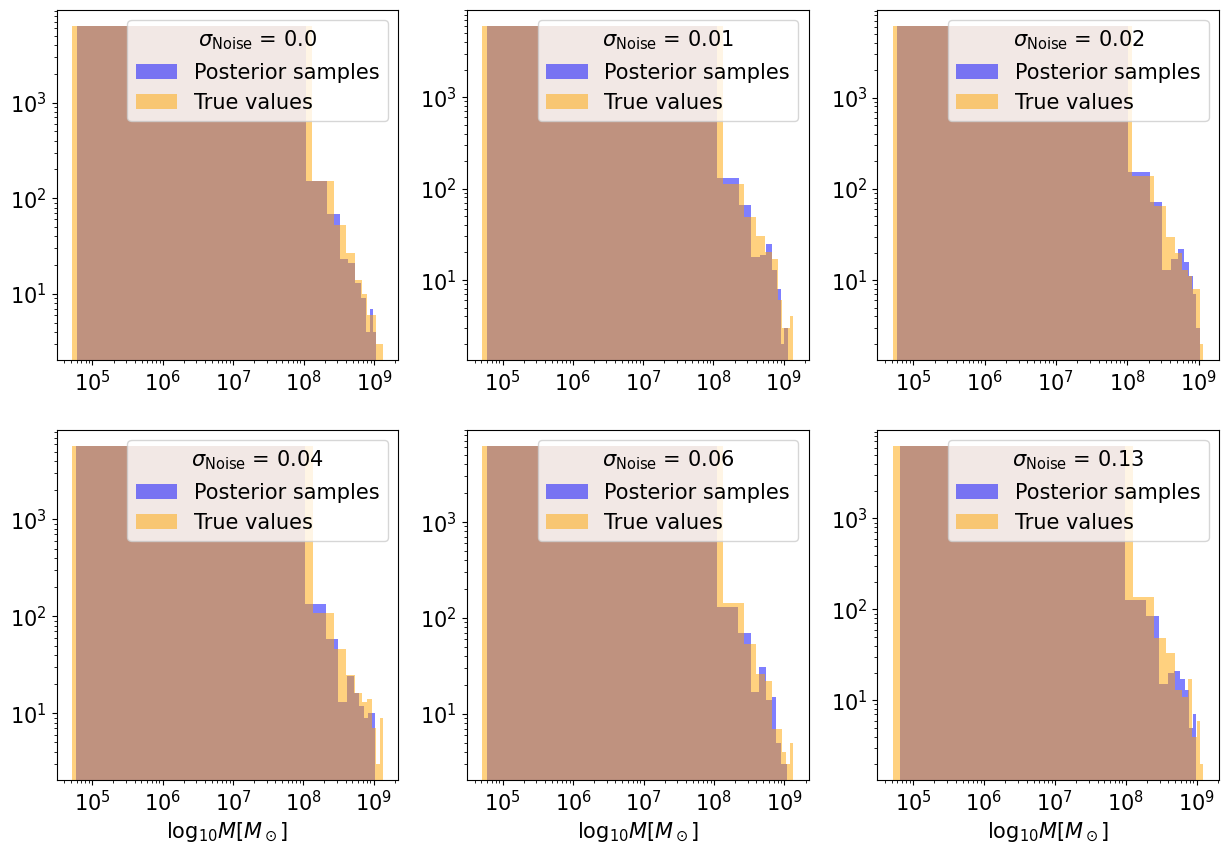

In [7]:
fig = plt.figure(figsize=(15, 10))

for i, s in enumerate(sigma):
    ax = fig.add_subplot(2, 3, i+1)
    ax.hist(10**np.array(mean_for_hist[s]['samples']), alpha=0.5, color='blue', label='Posterior samples', )
    ax.hist(10**np.array(mean_for_hist[s]['true']), alpha=0.5, color='orange', label='True values', )
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yscale('log')
    if i+1 > 3:
        ax.set_xlabel(r'$\text{log}_{10} M [M_\odot] $', fontsize=15)
    legend = ax.legend(title=fr'$\sigma_{{\text{{Noise}}}}$ = {s}',fontsize=15)
    plt.setp(legend.get_title(), fontsize=15, ha='left')
    

Integral of the power law function: 0.24516090568558246


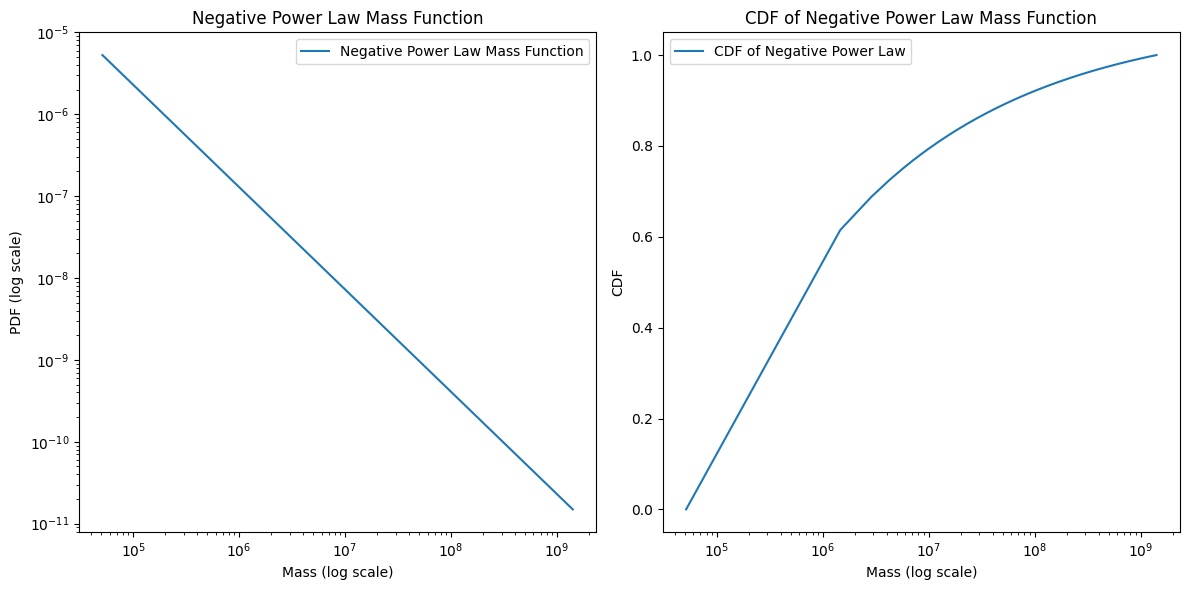

In [57]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.25
m_max = 1.41e9
m_min = 10**4.71

def pdf(m, m_max, m_min, alpha):
    """
    Power law mass function
    
    Parameters:
    m: mass of the galaxy
    m_max: maximum mass of the galaxy
    m_min: minimum mass of the galaxy
    alpha: power law index of the mass function
    
    Returns:
    pdf: power law mass function value at mass m
    """
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* m**(-alpha)

def integral_power_law(m_max, m_min, alpha):
    """
    Integral of the power law mass function
    
    Parameters:
    m_max: maximum mass of the galaxy
    m_min: minimum mass of the galaxy
    alpha: power law index of the mass function
    
    Returns:
    integral: integral of the power law mass function over the range [m_min, m_max]
    """
    if alpha == 1:
        return np.log(m_max / m_min)
    else:
        return (m_max**(1-alpha) - m_min**(1-alpha)) / (1-alpha)

def cdf(m, m_max, m_min, alpha):
    """
    Cumulative distribution function of the power law mass function
    
    Parameters:
    m: mass of the galaxy
    m_max: maximum mass of the galaxy
    m_min: minimum mass of the galaxy
    alpha: power law index of the mass function
    
    Returns:
    cdf: cumulative distribution function value at mass m
    """
    if alpha == 1:
        return (np.log(m) - np.log(m_min)) / (np.log(m_max) - np.log(m_min))
    else:
        return (m**(1-alpha) - m_min**(1-alpha)) / (m_max**(1-alpha) - m_min**(1-alpha))

# Generate data points
m_values = np.linspace(m_min, m_max, 1000)
pdf_values = pdf(m=m_values, m_max=m_max, m_min=m_min, alpha=alpha)
cdf_values = cdf(m=m_values, m_max=m_max, m_min=m_min, alpha=alpha)

# Compute the integral of the power law function
integral_value = integral_power_law(m_max, m_min, alpha)
print(f"Integral of the power law function: {integral_value}")

# Plot the negative power law function (PDF)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(m_values, pdf_values, label='Negative Power Law Mass Function')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass (log scale)')
plt.ylabel('PDF (log scale)')
plt.title('Negative Power Law Mass Function')
plt.legend()

# Plot the CDF
plt.subplot(1, 2, 2)
plt.plot(m_values, cdf_values, label='CDF of Negative Power Law')
plt.xscale('log')
plt.xlabel('Mass (log scale)')
plt.ylabel('CDF')
plt.title('CDF of Negative Power Law Mass Function')
plt.legend()

plt.tight_layout()
plt.show()